# ETL

We need to extract our information from Cartolafc oficial API, we are using those links for further reference:


1. [Devs Community](https://gitter.im/cartrolandofc/dev)
2. [Non Official Github](https://github.com/wgenial/cartrolandofc/blob/master/nova-api.md)


In [40]:
import requests


def get_base_atleta(rodada:int) -> dict:
    """
    Essa função nos retornará a base de atletas para determinada rodada
    """
    f = requests.get(f"https://api.cartolafc.globo.com/atletas/pontuados/{str(rodada)}")
    data = f.json()
    return data

In [90]:
?data

We need to separate our process into 4 points (Atllta, Club, Posições, Rodada e Total_Atleta)

We'll undestand then one per time.

In [54]:
data = get_base_atleta(1)

data.keys()

dict_keys(['atletas', 'clubes', 'posicoes', 'rodada', 'total_atletas'])

## Atletas

In [34]:
data['atletas'].keys()

dict_keys(['100079', '100103', '100652', '100763', '100844', '100846', '100848', '100943', '100969', '100987', '101054', '101077', '101314', '101422', '101431', '101573', '101595', '101708', '101715', '101717', '101729', '101798', '101960', '102292', '102299', '102302', '102318', '102330', '102352', '102878', '103099', '103295', '103445', '103695', '103912', '104075', '104125', '104127', '104250', '104257', '104401', '104459', '104519', '104649', '104754', '105294', '105584', '105585', '105811', '105840', '105901', '105902', '106002', '106047', '106305', '106822', '106843', '107110', '107172', '107744', '107745', '107754', '107759', '107991', '108176', '108201', '108713', '109282', '109497', '109573', '109963', '110415', '110506', '110607', '110633', '110745', '110760', '110948', '111333', '111547', '111578', '111695', '111829', '37245', '38133', '38141', '38162', '38229', '38277', '38279', '38315', '38394', '38545', '38877', '38913', '39148', '42116', '42145', '42234', '42411', '42500

In [215]:
data['atletas']['100079']

{'scout': {'FC': 1, 'FS': 1},
 'apelido': 'Zaracho',
 'foto': 'https://s.glbimg.com/es/sde/f/2021/04/23/ccb1d73771f04699045f78f794f4481d_FORMATO.png',
 'pontuacao': 0,
 'posicao_id': 4,
 'clube_id': 282,
 'entrou_em_campo': True}

Quantos atletas estamos trabalhando?; 

In [53]:
for i in range(1,5):
    base = get_base_atleta(i)
    print(len(base['atletas'].keys()))

330
299
296
295


Vimos que, para rodadas distintas, temos quantidade distintas de atletas na base, provavelmente por 2 possíveis motivos.

* Nossa base só nos mostra atletas que tiveram alguma pontuação
* Nossa base mostra todos atletas ativos, mas temos situações de atletas que saem e entram durante o campeonato

In [71]:
base  = get_base_atleta(2)
atletas_sem_jogar = []

while True:
    for atleta in list(base['atletas'].keys()):
        ref_entrou_em_campo =  base['atletas'][atleta]['entrou_em_campo']
        if ref_entrou_em_campo == False: 
            atletas_sem_jogar.append(atleta)
            if len(atletas_sem_jogar) == 10:
                break
    break
print(atletas_sem_jogar)

['105901', '107759', '71844', '97341', '98057']


Percebemos que nossa base só mostra jogadores que essencialmente jogaram, ou entraram em campo, ou pontuaram por ter algum scout mesmo ainda no banco, casos que o jogador levou um cartão mesmo no banco

In [76]:
base['atletas']['105901']

{'scout': {'CA': 1},
 'apelido': 'Edson',
 'foto': 'https://s.glbimg.com/es/sde/f/2021/04/19/8d94dd065da412fdee0c826a793a5eed_FORMATO.png',
 'pontuacao': -2,
 'posicao_id': 4,
 'clube_id': 265,
 'entrou_em_campo': False}

* Exemplo Edson rodada 2, Bragantino vs Bahia

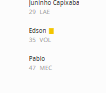

In [78]:
base['atletas']['97341']

{'scout': None,
 'apelido': 'Rogério Ceni',
 'foto': 'https://s.glbimg.com/es/sde/f/2020/11/09/8879b35c72aef797d229636dbdf3dd4f_FORMATO.png',
 'pontuacao': 0,
 'posicao_id': 6,
 'clube_id': 262,
 'entrou_em_campo': False}

In [19]:
data['atletas']['100079']

{'scout': {'FC': 1, 'FS': 1},
 'apelido': 'Zaracho',
 'foto': 'https://s.glbimg.com/es/sde/f/2021/04/23/ccb1d73771f04699045f78f794f4481d_FORMATO.png',
 'pontuacao': 0,
 'posicao_id': 4,
 'clube_id': 282,
 'entrou_em_campo': True}

In [112]:
data['atletas']['100079'].keys()

dict_keys(['scout', 'apelido', 'foto', 'pontuacao', 'posicao_id', 'clube_id', 'entrou_em_campo'])

In [275]:
#Gerando base como dicionário vazio a ser preenchido

#Gerando lista de possíveis scouts::::
def get_colunas_scout(data:dict) -> list:
    id_atletas = list(data['atletas'].keys())
    colunas_scouts = []
    for id in id_atletas:
        if data['atletas'][id]['scout']:   #Se existe scout
            for scout in data['atletas'][id]['scout'].keys(): #para cada scout do atleta
                if scout not in colunas_scouts:
                    colunas_scouts.append(scout)
    return colunas_scouts
    
def get_dataframe_atletas(rodada_atual:int) -> pd.DataFrame:
    #Where the magic begins

    # Definindo minhas colunas a serem utilizadas
    data_1_rodada = get_base_atleta(1) #Estamos considerando que todos os scouts necessários estarão sendo mapeados desde a 1 rodada.
    colunas_scouts = get_colunas_scout(data_1_rodada)
    colunas_base = ["rodada","apelido",'atleta_id','posicao_id',"clube_id","entrou_em_campo","pontuacao"]
    base = dict()
    colunas_final = colunas_base + colunas_scouts
    for coluna in colunas_final:
        base[coluna] = []
    
    #Gerando para nossa rodada atual 
    data = get_base_atleta(rodada_atual)
    id_atletas = list(data['atletas'].keys())
    for id in id_atletas:
        for coluna in colunas_final:  
            if coluna == 'rodada':
                base['rodada'].append(rodada_atual)
            elif coluna == 'atleta_id':
                base['atleta_id'].append(id)
            elif coluna in colunas_scouts:
                if data['atletas'][id]['scout']:
                    if coluna in data['atletas'][id]['scout'].keys():
                        base[coluna].append(data['atletas'][id]['scout'][coluna])
                    else:
                        base[coluna].append(0)
                else:
                    base[coluna].append(0)
            else:
                base[coluna].append(data['atletas'][id][coluna])
    return pd.DataFrame(base)

#print(base)

Conseguimos gerar nossa base de Jogadores e suas pontuações parametrizado pela coluna de ref.

In [276]:
df = get_dataframe_atletas(15)
df.tail()

,rodada,apelido,atleta_id,posicao_id,clube_id,entrou_em_campo,pontuacao,FC,FS,PI,...,FD,SG,CA,FT,G,PC,PS,PP,I,DP
297,15,Jean Pyerre,98832,4,284,True,-0.4,2,1,9,...,0,0,0,0,0,0,0,0,0,0
298,15,Derlan,98945,3,315,True,-3.3,0,0,3,...,0,0,1,0,0,1,0,0,0,0
299,15,Lucas Braga,99119,5,277,True,-0.7,2,1,7,...,0,0,0,0,0,0,0,0,1,0
300,15,Michael,99392,5,262,True,1.7,0,0,3,...,1,0,0,0,0,0,0,0,0,0
301,15,Baralhas,99440,4,373,True,2.6,2,0,6,...,1,0,0,0,0,0,0,0,0,0


## Clubes

In [228]:
data = get_base_atleta(1)

data['clubes'].keys()

dict_keys(['1371', '262', '264', '265', '266', '275', '276', '277', '280', '282', '284', '285', '286', '292', '293', '315', '327', '354', '356', '373'])

In [229]:
data['clubes']['293']

{'id': 293,
 'nome': 'Athlético-PR',
 'abreviacao': 'CAP',
 'escudos': {'60x60': 'https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png',
  '45x45': 'https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-45x45.png',
  '30x30': 'https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-30x30.png'},
 'nome_fantasia': 'Athlético-PR'}

Vamos avaliar se existe algum caso que o nome_fantasia esta diferente do nome oficial

In [231]:
lista_clubes = list(data['clubes'].keys())
for clube in lista_clubes:
    nome = data['clubes'][clube]['nome']
    nome_fantasia = data['clubes'][clube]['nome_fantasia']
    if nome != nome_fantasia:
        print("nok",nome,nome_fantasia)
    else:
        print("ok",nome,nome_fantasia)

ok Cuiabá Cuiabá
ok Flamengo Flamengo
ok Corinthians Corinthians
ok Bahia Bahia
ok Fluminense Fluminense
ok Palmeiras Palmeiras
ok São Paulo São Paulo
ok Santos Santos
ok Bragantino Bragantino
ok Atlético-MG Atlético-MG
ok Grêmio Grêmio
ok Internacional Internacional
ok Juventude Juventude
ok Sport Sport
ok Athlético-PR Athlético-PR
ok Chapecoense Chapecoense
ok América-MG América-MG
ok Ceará Ceará
ok Fortaleza Fortaleza
ok Atlético-GO Atlético-GO


In [233]:
for rodada in range(1,15):
    data = get_base_atleta(rodada)

    lista_clubes = list(data['clubes'].keys())
    for clube in lista_clubes:
        nome = data['clubes'][clube]['nome']
        nome_fantasia = data['clubes'][clube]['nome_fantasia']
        if nome != nome_fantasia:
            print("nok",nome,nome_fantasia)
        else:
            pass
            #print("ok",nome,nome_fantasia)

In [285]:
def get_dataframe_clubes(rodada_inicial=1) -> pd.DataFrame:
    data = get_base_atleta(rodada_inicial)
    base = {'clube_id':[],'clube_nome':[]}

    lista_clubes = list(data['clubes'].keys())
    for clube in lista_clubes: 
        for coluna in list(base.keys()):
            if coluna == 'clube_id':
                base[coluna].append(data['clubes'][clube]['id'])
            elif coluna == 'clube_nome':
                base[coluna].append(data['clubes'][clube]['nome'])
            else:
                base[coluna].append(data['clubes'][clube][coluna])
        
    return(pd.DataFrame(base))

In [286]:
df_clubes = get_dataframe_clubes()
df_clubes.head()

,clube_id,clube_nome
0,1371,Cuiabá
1,262,Flamengo
2,264,Corinthians
3,265,Bahia
4,266,Fluminense


## Posicoes

In [246]:
data = get_base_atleta(1)

In [247]:
data['posicoes']

{'1': {'id': 1, 'nome': 'Goleiro', 'abreviacao': 'gol'},
 '2': {'id': 2, 'nome': 'Lateral', 'abreviacao': 'lat'},
 '3': {'id': 3, 'nome': 'Zagueiro', 'abreviacao': 'zag'},
 '4': {'id': 4, 'nome': 'Meia', 'abreviacao': 'mei'},
 '5': {'id': 5, 'nome': 'Atacante', 'abreviacao': 'ata'},
 '6': {'id': 6, 'nome': 'Técnico', 'abreviacao': 'tec'}}

In [251]:
lista_id_posicoes = list(data['posicoes'].keys())
for id_posicao in lista_id_posicoes:
    nome = data['posicoes'][id_posicao]['nome']
    abreviacao = nome = data['posicoes'][id_posicao]['abreviacao']
    print(id_posicao,nome,abreviacao)

1 gol gol
2 lat lat
3 zag zag
4 mei mei
5 ata ata
6 tec tec


In [283]:
def get_dataframe_posicoes(rodada_inicial=1) -> pd.DataFrame:
    data = get_base_atleta(rodada_inicial)
    base = {'posicao_id':[],'posicao_nome':[],'posicao_abreviacao':[]}

    lista_posicoes = list(data['posicoes'].keys())
    for posicao in lista_posicoes: 
        for coluna in list(base.keys()):
            if coluna == 'posicao_id':
                base[coluna].append(data['posicoes'][posicao]['id'])
            elif coluna == 'posicao_nome':
                base[coluna].append(data['posicoes'][posicao]['nome'])
            elif coluna == 'posicao_abreviacao':
                base[coluna].append(data['posicoes'][posicao]['abreviacao'])
            else:
                base[coluna].append(data['posicoes'][posicao][coluna])
        
    return(pd.DataFrame(base))

In [284]:
df_posicoes = get_dataframe_posicoes()
df_posicoes

,posicao_id,posicao_nome,posicao_abreviacao
0,1,Goleiro,gol
1,2,Lateral,lat
2,3,Zagueiro,zag
3,4,Meia,mei
4,5,Atacante,ata
5,6,Técnico,tec


## rodada

In [270]:
data = get_base_atleta(1)

data['rodada']

1

## total_atletas

In [273]:
data = get_base_atleta(1)

data['total_atletas']

330

## DataFrame Final

In [290]:
rodada_atual = 10

df_atletas = get_dataframe_atletas(rodada_atual)
df_clubes = get_dataframe_clubes()
df_posicoes = get_dataframe_posicoes()

In [291]:
df.dtypes

rodada               int64
apelido             object
atleta_id           object
posicao_id           int64
clube_id             int64
entrou_em_campo       bool
pontuacao          float64
FC                   int64
FS                   int64
PI                   int64
FF                   int64
A                    int64
DS                   int64
DE                   int64
GS                   int64
FD                   int64
SG                   int64
CA                   int64
FT                   int64
G                    int64
PC                   int64
PS                   int64
PP                   int64
I                    int64
DP                   int64
clube_nome          object
dtype: object

In [292]:
df_clubes.dtypes

clube_id       int64
clube_nome    object
dtype: object

In [293]:
df_posicoes.dtypes

posicao_id             int64
posicao_nome          object
posicao_abreviacao    object
dtype: object

In [295]:
df_aux = pd.merge(df_atletas,df_clubes,on='clube_id',how='left')
df = pd.merge(df_aux,df_posicoes,on = 'posicao_id',how='left')
df.head()

,rodada,apelido,atleta_id,posicao_id,clube_id,entrou_em_campo,pontuacao,FC,FS,PI,...,FT,G,PC,PS,PP,I,DP,clube_nome,posicao_nome,posicao_abreviacao
0,10,Zaracho,100079,4,282,True,0.5,4,2,0,...,0,0,0,0,0,1,0,Atlético-MG,Meia,mei
1,10,Igor Gomes,100084,4,276,True,7.8,4,4,12,...,0,1,0,0,0,0,0,São Paulo,Meia,mei
2,10,Pedrinho,100103,5,280,True,0.4,0,1,1,...,0,0,0,0,0,0,0,Bragantino,Atacante,ata
3,10,Paulinho Bóia,100333,5,286,True,0.8,2,0,4,...,0,0,0,0,0,0,0,Juventude,Atacante,ata
4,10,Yuri Alberto,100652,5,285,True,0.6,3,4,11,...,0,0,0,0,0,0,0,Internacional,Atacante,ata


In [296]:
def get_dataframe_rodada(rodada_atual:int) -> pd.DataFrame:
    df_atletas = get_dataframe_atletas(rodada_atual)
    df_clubes = get_dataframe_clubes()
    df_posicoes = get_dataframe_posicoes()
    df_aux = pd.merge(df_atletas,df_clubes,on='clube_id',how='left')
    df = pd.merge(df_aux,df_posicoes,on = 'posicao_id',how='left')
    return df

In [344]:
df = get_dataframe_rodada(10)
df.tail()

,rodada,apelido,atleta_id,posicao_id,clube_id,entrou_em_campo,pontuacao,FC,FS,PI,...,FT,G,PC,PS,PP,I,DP,clube_nome,posicao_nome,posicao_abreviacao
294,10,Fernando Pacheco,98740,5,286,True,0.8,0,0,0,...,0,0,0,0,0,0,0,Juventude,Atacante,ata
295,10,Jean Pyerre,98832,4,284,True,1.0,0,1,3,...,0,0,0,0,0,0,0,Grêmio,Meia,mei
296,10,Viña,98974,2,275,True,15.0,0,0,8,...,0,0,0,0,0,0,0,Palmeiras,Lateral,lat
297,10,Michael,99392,5,262,True,0.3,0,1,5,...,0,0,0,0,0,3,0,Flamengo,Atacante,ata
298,10,Baralhas,99440,4,373,True,1.7,2,0,1,...,0,0,0,0,0,0,0,Atlético-GO,Meia,mei


## Salvando Nossos arquivos

In [348]:
import os

def salvando_resultado(rodada_atual:int,path:str):
    try:
        df = get_dataframe_rodada(rodada_atual)
        df.to_csv(f'{path}\\Base_Cartola_2021_rodada_{rodada_atual}.csv')
        print(f'Base carregada para pasta: {path}, na rodada: {rodada_atual}')
    except Exception as err:
        print(f"Não foi possível carregar tabela {rodada_atual}")

In [349]:
path_data = str(f"{os.getcwd()}\\data")
arquivos_salvos = [file for file in os.listdir(path_data) if file.endswith('csv')]
rodadas_carregadas = []
for arquivo in arquivos_salvos:
    ref = arquivo[:-4]
    rodada = ref.split("_")[-1]
    rodadas_carregadas.append(int(rodada))

In [350]:
for rodada in range(1,37):
    if rodada not in rodadas_carregadas:
        try:
            salvando_resultado(rodada,path_data)
        except Exception as err:
            print(err)

Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 1
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 2
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 3
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 4
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 5
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 6
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 7
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 8
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola\data, na rodada: 9
Base carregada para pasta: C:\Users\thiag\OneDrive\Área de Trabalho\GitHub\Cartola